## Try to predict the effect of mutation on splicing efficiency change

In [1]:
from keras.models import load_model
from concise.preprocessing import encodeDNA

import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import joblib
import matplotlib.pyplot as plt
%matplotlib inline 

%load_ext autoreload
%autoreload 2

import mmsplice
from mmsplice.generic import logit, expit

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes
projectDIR = '../../data/'

Using TensorFlow backend.


In [2]:
dt = pd.read_csv(projectDIR+"mapsy/mapsy.txt")

In [3]:
dt.head()

,ID,WT_ID,MUT_ID,WT_SEQ,MUT_SEQ,Exon_Start,Vivo_WT_Spliced,chr,Exon_End,Vivo_MUT_Spliced,...,phastCons46way_placental,phastCons46way_primate,phyloP100way_vertebrate,phyloP46way_primate,Exon_Pos,test,Exon_PhastCons,acceptor_intronL,donor_intronL,Exon_eng
0,CM000008W_CM000008M,CM000008W,CM000008M,CTTATGCGAACGTGATCTAACAAGTGCAACTATATTTCTATTAAAG...,CTTATGCGAACGTGATCTAACAAGTGCAACTATATTTCTATTAAAG...,49565166,367,chr20,49565199,315,...,1.000,0.092,6.229,0.460,0.300000,False,0.945515,6523.0,2705.0,-2.0
1,CM000044W_CM000044M,CM000044W,CM000044M,CTTATGCGAACGTGAATTAGCTCTACAGTGTTTTAGTATAGATACA...,CTTATGCGAACGTGAATTAGCTCTACAGTGTTTTAGTATAGATACA...,130714887,53,chr3,130714955,31,...,1.000,0.965,7.681,0.491,0.814815,True,0.992529,1944.0,568.0,-7.0
2,CM000130W_CM000130M,CM000130W,CM000130M,CTTATGCGAACGTGAGCCCCAGAGACAAAACATATTTATTAGAAGT...,CTTATGCGAACGTGAGCCCCAGAGACAAAACATATTTATTAGAAGT...,15518633,186,chr3,15518704,358,...,1.000,0.991,4.547,0.561,0.352941,False,0.920901,1779.0,1638.0,-32.4
3,CM000143W_CM000143M,CM000143W,CM000143M,CTTATGCGAACGTGATGACTCTTGTCTTTTCATAGTTGACACATTA...,CTTATGCGAACGTGATGACTCTTGTCTTTTCATAGTTGACACATTA...,44130744,716,chr11,44130833,405,...,1.000,0.994,3.955,0.655,0.214286,False,0.946933,945.0,4901.0,-21.4
4,CM000143W_CM010237M,CM000143W,CM010237M,CTTATGCGAACGTGATGACTCTTGTCTTTTCATAGTTGACACATTA...,CTTATGCGAACGTGATGACTCTTGTCTTTTCATAGTTGACACATTA...,44130744,716,chr11,44130833,262,...,0.966,0.728,7.711,0.655,0.214286,False,0.946933,945.0,4901.0,-21.4


Match donor and acceptor position in the given sequence

In [4]:
dt.shape

(4951, 38)

### Convert a vcf file

In [5]:
import sys
sys.path.append("../")
from utils import find_pos, find_seq_diff_pos

In [6]:
dt['WT_Exon_End'] = dt.apply(lambda x: find_pos(x["WT_SEQ"], x["donor"]), axis=1)

dt['WT_Exon_Start'] = dt.apply(lambda x: find_pos(x["WT_SEQ"], x["acceptor"], start=False), axis=1)

In [7]:
dt['MUT_Exon_End'] = dt.apply(lambda x: find_pos(x["MUT_SEQ"], x["donor"]), axis=1)

dt['MUT_Exon_Start'] = dt.apply(lambda x: find_pos(x["MUT_SEQ"], x["acceptor"], start=False), axis=1)

In [8]:
dt["MUT_POS"] = dt.apply(lambda x: find_seq_diff_pos(x["WT_SEQ"], x["MUT_SEQ"]), axis=1)

../utils.py:36: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  return find(muts)[0]


In [9]:
dt['exonL'] = (dt["Exon_End"] - dt["Exon_Start"])

In [10]:
## distance to spice sites
dt['Dist_SS'] = dt.apply(lambda x: min(x['MUT_POS']-x["MUT_Exon_Start"], x["MUT_Exon_End"]-x['MUT_POS']), axis=1)

In [11]:
# Prepare a vcf file
POS = dt['MUT_POS'] - dt["MUT_Exon_Start"] + dt['Exon_Start']
REF = dt.apply(lambda x: x['WT_SEQ'][x['MUT_POS']], axis=1)
ALT = dt.apply(lambda x: x['MUT_SEQ'][x['MUT_POS']], axis=1)

In [12]:
prevcf = pd.DataFrame({"ID": dt.apply(lambda x: x['WT_ID']+"_"+x["MUT_ID"], axis=1),
             "POS": POS,
             "REF": REF,
             "ALT": ALT,
             "CHROM": dt['chr']})

### Get feature sequence

In [13]:
acceptor_wt = dt.apply(lambda x: x['WT_SEQ'][x['WT_Exon_Start']-50 : x['WT_Exon_Start']+3], axis=1)

donor_wt = dt.apply(lambda x: x['WT_SEQ'][x['WT_Exon_End']-5 : x['WT_Exon_End']+13], axis=1)

In [14]:
acceptor_mut = dt.apply(lambda x: x['MUT_SEQ'][x['MUT_Exon_Start']-50 : x['MUT_Exon_Start']+3], axis=1)

donor_mut = dt.apply(lambda x: x['MUT_SEQ'][x['MUT_Exon_End']-5 : x['MUT_Exon_End']+13], axis=1)

In [15]:
exon_wt_seq = dt.apply(lambda x: x['WT_SEQ'][x['WT_Exon_Start'] : x['WT_Exon_End']], axis=1)
exon_mut_seq = dt.apply(lambda x: x['MUT_SEQ'][x['MUT_Exon_Start'] : x['MUT_Exon_End']], axis=1)

In [16]:
def label_region(mut_pos, exon_start, exon_end, left=3, right=5):
    """ left: how many bases of start of exon to be considered as acceptor region
    right: how many bases of end of exon to be considered as donor region
    """ 
    if mut_pos < exon_start + left:
        return 'acceptor'
    elif mut_pos > exon_end - right:
        return 'donor'
    else:
        return 'exon'

In [17]:
dt['REGION'] = dt.apply(lambda x: label_region(x["MUT_POS"], x["WT_Exon_Start"], x["WT_Exon_End"]), axis=1)

## Apply model

In [18]:
exonM = load_model(mmsplice.EXON)
exon_wt = exonM.predict_on_batch(encodeDNA(exon_wt_seq))

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
exon_mut = exonM.predict_on_batch(encodeDNA(exon_mut_seq))

In [20]:
donorM = load_model(mmsplice.DONOR)
donor_wt = donorM.predict_on_batch(encodeDNA(donor_wt))
donor_mut = donorM.predict_on_batch(encodeDNA(donor_mut))

In [21]:
acceptorM = load_model(mmsplice.ACCEPTOR)
acceptor_wt = acceptorM.predict_on_batch(encodeDNA(acceptor_wt))
acceptor_mut = acceptorM.predict_on_batch(encodeDNA(acceptor_mut))

## Huber loss regression

In [22]:
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV

In [23]:
X_vivo = np.concatenate([logit(acceptor_mut)-logit(acceptor_wt), exon_mut-exon_wt, logit(donor_mut)-logit(donor_wt)], axis=1)

exon_overlap = np.logical_or(np.logical_and(X_vivo[:,0]!=0, X_vivo[:,1]!=0), np.logical_and(X_vivo[:,1]!=0, X_vivo[:,2]!=0))
X_vivo = np.hstack([X_vivo, (X_vivo[:,1]*exon_overlap).reshape(-1,1)])

In [24]:
X_vitro = np.concatenate([logit(acceptor_mut)-logit(acceptor_wt), exon_mut-exon_wt], axis=1)

exon_overlap = np.logical_and(X_vitro[:,0]!=0, X_vitro[:,1]!=0)
X_vitro = np.hstack([X_vitro, (X_vitro[:,1]*exon_overlap).reshape(-1,1)])

### In vitro

In [25]:
keep = np.isfinite(dt.log2_vitro_ratio)

In [26]:
huber = HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100)

In [27]:
param_dist = [{'epsilon': np.linspace(1, 4, 30)}]

cv = GridSearchCV(huber, param_dist)

cv.fit(X_vitro[keep], dt.log2_vitro_ratio[keep])

GridSearchCV(cv=None, error_score='raise',
       estimator=HuberRegressor(alpha=0.0, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'epsilon': array([1.     , 1.10345, 1.2069 , 1.31034, 1.41379, 1.51724, 1.62069,
       1.72414, 1.82759, 1.93103, 2.03448, 2.13793, 2.24138, 2.34483,
       2.44828, 2.55172, 2.65517, 2.75862, 2.86207, 2.96552, 3.06897,
       3.17241, 3.27586, 3.37931, 3.48276, 3.58621, 3.68966, 3.7931 ,
       3.89655, 4.     ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
y_pred_vitro = cv.best_estimator_.predict(X_vitro[keep])

In [29]:
vitro = np.stack([dt.log2_vitro_ratio[keep].as_matrix(), y_pred_vitro], axis=1)
np.savetxt(projectDIR+"mapsy/Vitro_Pred_huber.txt", vitro)

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [30]:
r = pearsonr(dt.log2_vitro_ratio[keep], y_pred_vitro)[0]

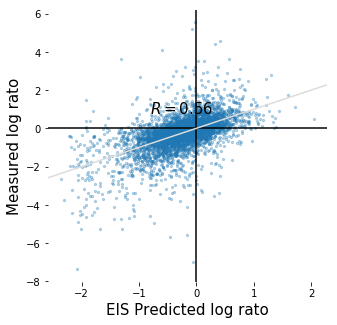

In [31]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.scatter(y_pred_vitro, dt.log2_vitro_ratio[keep], s=5, alpha=0.3) # delta_pred[keep]
ax.axvline(x=0, color='k') 
ax.axhline(y=0, color='k')
# ax.axis([-10,10,-10,10])
ax.set_xlabel("EIS Predicted log rato", fontsize=15)
ax.set_ylabel("Measured log rato", fontsize=15)
ax.text(-0.8,0.8,'$R=%0.2f$'%r,fontsize=15)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
add_identity(ax, color="#DCDCDC")
plt.show()

In [32]:
huber_best = cv.best_estimator_
joblib.dump(huber_best, projectDIR + "mapsy/vitro_model.pkl")

['../../data/mapsy/vitro_model.pkl']

### In vivo

In [33]:
huber = HuberRegressor(fit_intercept=True, max_iter=100)

In [34]:
keep = np.isfinite(dt.log2_vivo_ratio)

In [35]:
param_dist = [{'epsilon': np.linspace(1, 4, 30)}]

cv = GridSearchCV(huber, param_dist)

cv.fit(X_vivo[keep], dt.log2_vivo_ratio[keep])

GridSearchCV(cv=None, error_score='raise',
       estimator=HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'epsilon': array([1.     , 1.10345, 1.2069 , 1.31034, 1.41379, 1.51724, 1.62069,
       1.72414, 1.82759, 1.93103, 2.03448, 2.13793, 2.24138, 2.34483,
       2.44828, 2.55172, 2.65517, 2.75862, 2.86207, 2.96552, 3.06897,
       3.17241, 3.27586, 3.37931, 3.48276, 3.58621, 3.68966, 3.7931 ,
       3.89655, 4.     ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
y_pred_vivo = cv.best_estimator_.predict(X_vivo[keep])

In [37]:
vivo = np.stack([dt.log2_vivo_ratio[keep].as_matrix(), y_pred_vivo], axis=1)
np.savetxt(projectDIR+"mapsy/Vivo_Pred_huber.txt", vivo)

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [38]:
r = pearsonr(y_pred_vivo, dt.log2_vivo_ratio[keep])[0]

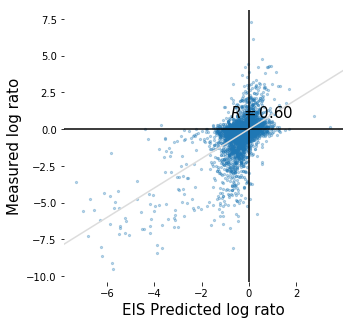

In [39]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.scatter(y_pred_vivo, dt.log2_vivo_ratio[keep], s=5, alpha=0.3)
ax.axvline(x=0, color='k')
ax.axhline(y=0, color='k')
# ax.axis([-10,10,-10,10])
ax.set_xlabel("EIS Predicted log rato", fontsize=15)
ax.set_ylabel("Measured log rato", fontsize=15)
ax.text(-0.8,0.8,'$R=%0.2f$'%r,fontsize=15)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
add_identity(ax, color="#DCDCDC")
plt.show()

In [40]:
huber_best = cv.best_estimator_
joblib.dump(huber_best, projectDIR + "mapsy/vivo_model.pkl")

['../../data/mapsy/vivo_model.pkl']